## Import Data ##

In [353]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import *
import time
import warnings
import os

warnings.filterwarnings("ignore", category=DeprecationWarning)

device = "mps" if torch.mps.is_available() else "cpu"
print(device)

mps


In [355]:
files = os.listdir()
data = [f for f in files if f.endswith(".csv")]

if data:
    df = pd.read_csv(data[0])
else:
    print("No data files found in the directory.")

df

Patient_ID  Age  Gender Nationality         Emirate Diagnosis_Date  \
0     PAT000001   69  Female     Emirati   Umm Al Quwain     2020-11-30   
1     PAT000002   32    Male     Emirati   Umm Al Quwain     2015-10-10   
2     PAT000003   89    Male     Emirati       Abu Dhabi     2018-02-13   
3     PAT000004   78  Female     Emirati       Abu Dhabi     2022-02-04   
4     PAT000005   38  Female     Emirati        Fujairah     2019-12-03   
...         ...  ...     ...         ...             ...            ...   
9995  PAT009996   88    Male     Emirati  Ras Al Khaimah     2016-01-21   
9996  PAT009997   43    Male     Emirati         Sharjah     2018-12-06   
9997  PAT009998   63  Female     Emirati         Sharjah     2016-06-11   
9998  PAT009999   63  Female     Emirati       Abu Dhabi     2018-11-12   
9999  PAT010000   31    Male  Expatriate           Dubai     2017-09-16   

     Cancer_Type Cancer_Stage Treatment_Type Treatment_Start_Date  \
0          Liver           II      Radiation           2020-12-04   
1       Leukemia          III        Surgery           2015-11-05   
2          Liver          III      Radiation           2018-08-03   
3           Lung          III      Radiation           2022-03-13   
4     Pancreatic           II   Chemotherapy           2020-02-29   
...          ...          ...            ...                  ...   
9995     Ovarian           II        Surgery           2016-04-03   
9996     Ovarian          III      Radiation           2019-03-23   
9997        Lung          III   Chemotherapy           2016-10-21   
9998        Lung           IV  Immunotherapy           2019-02-05   
9999       Liver            I      Radiation           2017-12-23   

                        Hospital Primary_Physician          Outcome  \
0        Sheikh Khalifa Hospital          Dr. VO41        Recovered   
1                 Dubai Hospital          Dr. SM31        Recovered   
2        Zayed Military Hospital           Dr. BC7  Under Treatment   
3     Cleveland Clinic Abu Dhabi          Dr. TC14        Recovered   
4        Sheikh Khalifa Hospital          Dr. YS37        Recovered   
...                          ...               ...              ...   
9995     Sheikh Khalifa Hospital          Dr. FJ27        Recovered   
9996  Cleveland Clinic Abu Dhabi          Dr. JB17  Under Treatment   
9997              Dubai Hospital          Dr. ZG45  Under Treatment   
9998  Cleveland Clinic Abu Dhabi          Dr. EL16        Recovered   
9999     Zayed Military Hospital          Dr. SI45  Under Treatment   

     Death_Date Cause_of_Death Smoking_Status           Comorbidities  \
0           NaN            NaN     Non-Smoker                     NaN   
1           NaN            NaN         Smoker                     NaN   
2           NaN            NaN     Non-Smoker                     NaN   
3           NaN            NaN  Former Smoker                     NaN   
4           NaN            NaN  Former Smoker                     NaN   
...         ...            ...            ...                     ...   
9995        NaN            NaN         Smoker  Cardiovascular Disease   
9996        NaN            NaN     Non-Smoker                Diabetes   
9997        NaN            NaN     Non-Smoker                     NaN   
9998        NaN            NaN         Smoker            Hypertension   
9999        NaN            NaN         Smoker            Hypertension   

        Ethnicity  Weight  Height  
0        European      61     157  
1     South Asian      80     175  
2     South Asian      50     175  
3         African      44     155  
4      East Asian     101     160  
...           ...     ...     ...  
9995     European      55     168  
9996      African      98     175  
9997   East Asian      92     165  
9998     European      68     193  
9999   East Asian      56     173  

[10000 rows x 20 columns]

In [357]:
#If columns need to be dropped
df.drop(columns=["Patient_ID"], inplace=True, axis=1)

In [359]:
from sklearn.preprocessing import LabelEncoder

#Words to numbers
le = LabelEncoder()
for column in df.columns:
    if df[column].dtype == "object":
        df[column] = le.fit_transform(df[column])

In [361]:
#Standardize data, helpful for linear regression and Neural Networks

copy_df = df.copy()

for column in copy_df.columns:
    copy_df[column] = copy_df[column]/copy_df[column].abs().max()
copy_df

Age  Gender  Nationality   Emirate  Diagnosis_Date  Cancer_Type  \
0     0.775281     0.0          0.0  1.000000        0.646984     0.428571   
1     0.359551     0.5          0.0  1.000000        0.085714     0.285714   
2     1.000000     0.5          0.0  0.000000        0.340635     0.428571   
3     0.876404     0.0          0.0  0.000000        0.775238     0.571429   
4     0.426966     0.0          0.0  0.500000        0.537143     0.857143   
...        ...     ...          ...       ...             ...          ...   
9995  0.988764     0.5          0.0  0.666667        0.117143     0.714286   
9996  0.483146     0.5          0.0  0.833333        0.428889     0.714286   
9997  0.707865     0.0          0.0  0.833333        0.160317     0.571429   
9998  0.707865     0.0          0.0  0.000000        0.421270     0.571429   
9999  0.348315     0.5          1.0  0.333333        0.297460     0.428571   

      Cancer_Stage  Treatment_Type  Treatment_Start_Date  Hospital  \
0         0.333333        0.666667              0.614651  0.666667   
1         0.666667        1.000000              0.076639  0.333333   
2         0.666667        0.666667              0.366882  1.000000   
3         0.666667        0.666667              0.751924  0.000000   
4         0.333333        0.000000              0.533395  0.666667   
...            ...             ...                   ...       ...   
9995      0.333333        1.000000              0.120653  0.666667   
9996      0.666667        0.666667              0.433980  0.000000   
9997      0.666667        0.000000              0.178209  0.333333   
9998      1.000000        0.333333              0.420745  0.000000   
9999      0.000000        0.666667              0.302247  1.000000   

      Primary_Physician  Outcome  Death_Date  Cause_of_Death  Smoking_Status  \
0              0.828863      0.5         1.0             1.0             0.5   
1              0.708116      0.5         1.0             1.0             1.0   
2              0.042842      1.0         1.0             1.0             0.5   
3              0.729130      0.5         1.0             1.0             0.0   
4              0.948914      0.5         1.0             1.0             0.0   
...                 ...      ...         ...             ...             ...   
9995           0.204458      0.5         1.0             1.0             1.0   
9996           0.348775      1.0         1.0             1.0             0.5   
9997           0.970510      1.0         1.0             1.0             0.5   
9998           0.169047      0.5         1.0             1.0             1.0   
9999           0.702543      1.0         1.0             1.0             1.0   

      Comorbidities  Ethnicity    Weight    Height  
0          1.000000       0.75  0.500000  0.754808  
1          1.000000       1.00  0.655738  0.841346  
2          1.000000       1.00  0.409836  0.841346  
3          1.000000       0.00  0.360656  0.745192  
4          1.000000       0.50  0.827869  0.769231  
...             ...        ...       ...       ...  
9995       0.000000       0.75  0.450820  0.807692  
9996       0.333333       0.00  0.803279  0.841346  
9997       1.000000       0.50  0.754098  0.793269  
9998       0.666667       0.75  0.557377  0.927885  
9999       0.666667       0.50  0.459016  0.831731  

[10000 rows x 19 columns]

In [363]:
def drop():
    global X
    global y
    
    X = copy_df.drop(columns=["Outcome"])
    y = copy_df["Outcome"]

drop()
copy_df

Age  Gender  Nationality   Emirate  Diagnosis_Date  Cancer_Type  \
0     0.775281     0.0          0.0  1.000000        0.646984     0.428571   
1     0.359551     0.5          0.0  1.000000        0.085714     0.285714   
2     1.000000     0.5          0.0  0.000000        0.340635     0.428571   
3     0.876404     0.0          0.0  0.000000        0.775238     0.571429   
4     0.426966     0.0          0.0  0.500000        0.537143     0.857143   
...        ...     ...          ...       ...             ...          ...   
9995  0.988764     0.5          0.0  0.666667        0.117143     0.714286   
9996  0.483146     0.5          0.0  0.833333        0.428889     0.714286   
9997  0.707865     0.0          0.0  0.833333        0.160317     0.571429   
9998  0.707865     0.0          0.0  0.000000        0.421270     0.571429   
9999  0.348315     0.5          1.0  0.333333        0.297460     0.428571   

      Cancer_Stage  Treatment_Type  Treatment_Start_Date  Hospital  \
0         0.333333        0.666667              0.614651  0.666667   
1         0.666667        1.000000              0.076639  0.333333   
2         0.666667        0.666667              0.366882  1.000000   
3         0.666667        0.666667              0.751924  0.000000   
4         0.333333        0.000000              0.533395  0.666667   
...            ...             ...                   ...       ...   
9995      0.333333        1.000000              0.120653  0.666667   
9996      0.666667        0.666667              0.433980  0.000000   
9997      0.666667        0.000000              0.178209  0.333333   
9998      1.000000        0.333333              0.420745  0.000000   
9999      0.000000        0.666667              0.302247  1.000000   

      Primary_Physician  Outcome  Death_Date  Cause_of_Death  Smoking_Status  \
0              0.828863      0.5         1.0             1.0             0.5   
1              0.708116      0.5         1.0             1.0             1.0   
2              0.042842      1.0         1.0             1.0             0.5   
3              0.729130      0.5         1.0             1.0             0.0   
4              0.948914      0.5         1.0             1.0             0.0   
...                 ...      ...         ...             ...             ...   
9995           0.204458      0.5         1.0             1.0             1.0   
9996           0.348775      1.0         1.0             1.0             0.5   
9997           0.970510      1.0         1.0             1.0             0.5   
9998           0.169047      0.5         1.0             1.0             1.0   
9999           0.702543      1.0         1.0             1.0             1.0   

      Comorbidities  Ethnicity    Weight    Height  
0          1.000000       0.75  0.500000  0.754808  
1          1.000000       1.00  0.655738  0.841346  
2          1.000000       1.00  0.409836  0.841346  
3          1.000000       0.00  0.360656  0.745192  
4          1.000000       0.50  0.827869  0.769231  
...             ...        ...       ...       ...  
9995       0.000000       0.75  0.450820  0.807692  
9996       0.333333       0.00  0.803279  0.841346  
9997       1.000000       0.50  0.754098  0.793269  
9998       0.666667       0.75  0.557377  0.927885  
9999       0.666667       0.50  0.459016  0.831731  

[10000 rows x 19 columns]

## Data Clean Up ##

In [365]:
stats.zscore(copy_df) #Find outliers

Age    Gender  Nationality   Emirate  Diagnosis_Date  Cancer_Type  \
0     0.744849 -0.970892    -0.830174  1.513662        0.497872    -0.213778   
1    -1.037743  0.895131    -0.830174  1.513662       -1.443431    -0.652297   
2     1.708413  0.895131    -0.830174 -1.472453       -0.561719    -0.213778   
3     1.178453 -0.970892    -0.830174 -1.472453        0.941473     0.224741   
4    -0.748674 -0.970892    -0.830174  0.020604        0.117957     1.101778   
...        ...       ...          ...       ...             ...          ...   
9995  1.660234  0.895131    -0.830174  0.518290       -1.334727     0.663260   
9996 -0.507784  0.895131    -0.830174  1.015976       -0.256469     0.663260   
9997  0.455780 -0.970892    -0.830174  1.015976       -1.185396     0.224741   
9998  0.455780 -0.970892    -0.830174 -1.472453       -0.282821     0.224741   
9999 -1.085922  0.895131     1.204566 -0.477082       -0.711050    -0.213778   

      Cancer_Stage  Treatment_Type  Treatment_Start_Date  Hospital  \
0        -0.360160        0.445191              0.399756  0.454672   
1         0.632017        1.340769             -1.502246 -0.440351   
2         0.632017        0.445191             -0.476166  1.349695   
3         0.632017        0.445191              0.885049 -1.335374   
4        -0.360160       -1.345963              0.112497  0.454672   
...            ...             ...                   ...       ...   
9995     -0.360160        1.340769             -1.346647  0.454672   
9996      0.632017        0.445191             -0.238960 -1.335374   
9997      0.632017       -1.345963             -1.143172 -0.440351   
9998      1.624194       -0.450386             -0.285748 -1.335374   
9999     -1.352338        0.445191             -0.704667  1.349695   

      Primary_Physician   Outcome  Death_Date  Cause_of_Death  Smoking_Status  \
0              1.131819 -0.480784    0.284631        0.312853       -0.162226   
1              0.715052 -0.480784    0.284631        0.312853        1.275951   
2             -1.581170  1.077673    0.284631        0.312853       -0.162226   
3              0.787586 -0.480784    0.284631        0.312853       -1.600404   
4              1.546180 -0.480784    0.284631        0.312853       -1.600404   
...                 ...       ...         ...             ...             ...   
9995          -1.023345 -0.480784    0.284631        0.312853        1.275951   
9996          -0.525229  1.077673    0.284631        0.312853       -0.162226   
9997           1.620718  1.077673    0.284631        0.312853       -0.162226   
9998          -1.145569 -0.480784    0.284631        0.312853        1.275951   
9999           0.695817  1.077673    0.284631        0.312853        1.275951   

      Comorbidities  Ethnicity    Weight    Height  
0          0.993233   0.689438 -0.572573 -1.226214  
1          0.993233   1.392229  0.699812  0.561342  
2          0.993233   1.392229 -1.309217  0.561342  
3          0.993233  -1.418935 -1.711022 -1.424831  
4          0.993233  -0.013353  2.106131 -0.928288  
...             ...        ...       ...       ...  
9995      -1.997232   0.689438 -0.974379 -0.133818  
9996      -1.000410  -1.418935  1.905229  0.561342  
9997       0.993233  -0.013353  1.503423 -0.431744  
9998      -0.003589   0.689438 -0.103800  2.348898  
9999      -0.003589  -0.013353 -0.907411  0.362725  

[10000 rows x 19 columns]

In [367]:
#Drop outliers
z = np.abs(stats.zscore(copy_df))
threshold_z = 3
outliers = np.where(z > threshold_z)[0]
copy_df = copy_df.drop(outliers)
drop()
copy_df.shape

(9251, 19)

In [369]:
copy_df.isna().sum()

Age                     0
Gender                  0
Nationality             0
Emirate                 0
Diagnosis_Date          0
Cancer_Type             0
Cancer_Stage            0
Treatment_Type          0
Treatment_Start_Date    0
Hospital                0
Primary_Physician       0
Outcome                 0
Death_Date              0
Cause_of_Death          0
Smoking_Status          0
Comorbidities           0
Ethnicity               0
Weight                  0
Height                  0
dtype: int64

In [ ]:
copy_df = copy_df.dropna().reset_index(drop=True) #drop rows with missing values

In [371]:
copy_df.duplicated().sum()

0

In [ ]:
copy_df = copy_df.drop_duplicates().reset_index(drop=True) #drop duplicate rows

In [373]:
drop()
copy_df

Age  Gender  Nationality   Emirate  Diagnosis_Date  Cancer_Type  \
0     0.775281     0.0          0.0  1.000000        0.646984     0.428571   
1     0.359551     0.5          0.0  1.000000        0.085714     0.285714   
2     1.000000     0.5          0.0  0.000000        0.340635     0.428571   
3     0.876404     0.0          0.0  0.000000        0.775238     0.571429   
4     0.426966     0.0          0.0  0.500000        0.537143     0.857143   
...        ...     ...          ...       ...             ...          ...   
9995  0.988764     0.5          0.0  0.666667        0.117143     0.714286   
9996  0.483146     0.5          0.0  0.833333        0.428889     0.714286   
9997  0.707865     0.0          0.0  0.833333        0.160317     0.571429   
9998  0.707865     0.0          0.0  0.000000        0.421270     0.571429   
9999  0.348315     0.5          1.0  0.333333        0.297460     0.428571   

      Cancer_Stage  Treatment_Type  Treatment_Start_Date  Hospital  \
0         0.333333        0.666667              0.614651  0.666667   
1         0.666667        1.000000              0.076639  0.333333   
2         0.666667        0.666667              0.366882  1.000000   
3         0.666667        0.666667              0.751924  0.000000   
4         0.333333        0.000000              0.533395  0.666667   
...            ...             ...                   ...       ...   
9995      0.333333        1.000000              0.120653  0.666667   
9996      0.666667        0.666667              0.433980  0.000000   
9997      0.666667        0.000000              0.178209  0.333333   
9998      1.000000        0.333333              0.420745  0.000000   
9999      0.000000        0.666667              0.302247  1.000000   

      Primary_Physician  Outcome  Death_Date  Cause_of_Death  Smoking_Status  \
0              0.828863      0.5         1.0             1.0             0.5   
1              0.708116      0.5         1.0             1.0             1.0   
2              0.042842      1.0         1.0             1.0             0.5   
3              0.729130      0.5         1.0             1.0             0.0   
4              0.948914      0.5         1.0             1.0             0.0   
...                 ...      ...         ...             ...             ...   
9995           0.204458      0.5         1.0             1.0             1.0   
9996           0.348775      1.0         1.0             1.0             0.5   
9997           0.970510      1.0         1.0             1.0             0.5   
9998           0.169047      0.5         1.0             1.0             1.0   
9999           0.702543      1.0         1.0             1.0             1.0   

      Comorbidities  Ethnicity    Weight    Height  
0          1.000000       0.75  0.500000  0.754808  
1          1.000000       1.00  0.655738  0.841346  
2          1.000000       1.00  0.409836  0.841346  
3          1.000000       0.00  0.360656  0.745192  
4          1.000000       0.50  0.827869  0.769231  
...             ...        ...       ...       ...  
9995       0.000000       0.75  0.450820  0.807692  
9996       0.333333       0.00  0.803279  0.841346  
9997       1.000000       0.50  0.754098  0.793269  
9998       0.666667       0.75  0.557377  0.927885  
9999       0.666667       0.50  0.459016  0.831731  

[9251 rows x 19 columns]

In [375]:
col = copy_df.pop("Outcome")
copy_df.insert(copy_df.shape[1], col.name, col)

drop()
copy_df

Age  Gender  Nationality   Emirate  Diagnosis_Date  Cancer_Type  \
0     0.775281     0.0          0.0  1.000000        0.646984     0.428571   
1     0.359551     0.5          0.0  1.000000        0.085714     0.285714   
2     1.000000     0.5          0.0  0.000000        0.340635     0.428571   
3     0.876404     0.0          0.0  0.000000        0.775238     0.571429   
4     0.426966     0.0          0.0  0.500000        0.537143     0.857143   
...        ...     ...          ...       ...             ...          ...   
9995  0.988764     0.5          0.0  0.666667        0.117143     0.714286   
9996  0.483146     0.5          0.0  0.833333        0.428889     0.714286   
9997  0.707865     0.0          0.0  0.833333        0.160317     0.571429   
9998  0.707865     0.0          0.0  0.000000        0.421270     0.571429   
9999  0.348315     0.5          1.0  0.333333        0.297460     0.428571   

      Cancer_Stage  Treatment_Type  Treatment_Start_Date  Hospital  \
0         0.333333        0.666667              0.614651  0.666667   
1         0.666667        1.000000              0.076639  0.333333   
2         0.666667        0.666667              0.366882  1.000000   
3         0.666667        0.666667              0.751924  0.000000   
4         0.333333        0.000000              0.533395  0.666667   
...            ...             ...                   ...       ...   
9995      0.333333        1.000000              0.120653  0.666667   
9996      0.666667        0.666667              0.433980  0.000000   
9997      0.666667        0.000000              0.178209  0.333333   
9998      1.000000        0.333333              0.420745  0.000000   
9999      0.000000        0.666667              0.302247  1.000000   

      Primary_Physician  Death_Date  Cause_of_Death  Smoking_Status  \
0              0.828863         1.0             1.0             0.5   
1              0.708116         1.0             1.0             1.0   
2              0.042842         1.0             1.0             0.5   
3              0.729130         1.0             1.0             0.0   
4              0.948914         1.0             1.0             0.0   
...                 ...         ...             ...             ...   
9995           0.204458         1.0             1.0             1.0   
9996           0.348775         1.0             1.0             0.5   
9997           0.970510         1.0             1.0             0.5   
9998           0.169047         1.0             1.0             1.0   
9999           0.702543         1.0             1.0             1.0   

      Comorbidities  Ethnicity    Weight    Height  Outcome  
0          1.000000       0.75  0.500000  0.754808      0.5  
1          1.000000       1.00  0.655738  0.841346      0.5  
2          1.000000       1.00  0.409836  0.841346      1.0  
3          1.000000       0.00  0.360656  0.745192      0.5  
4          1.000000       0.50  0.827869  0.769231      0.5  
...             ...        ...       ...       ...      ...  
9995       0.000000       0.75  0.450820  0.807692      0.5  
9996       0.333333       0.00  0.803279  0.841346      1.0  
9997       1.000000       0.50  0.754098  0.793269      1.0  
9998       0.666667       0.75  0.557377  0.927885      0.5  
9999       0.666667       0.50  0.459016  0.831731      1.0  

[9251 rows x 19 columns]

## Statistical Modeling ##

Shape:  (9251, 19)

Counts:
 Outcome
0.5    4909
1.0    4054
0.0     288
Name: count, dtype: int64



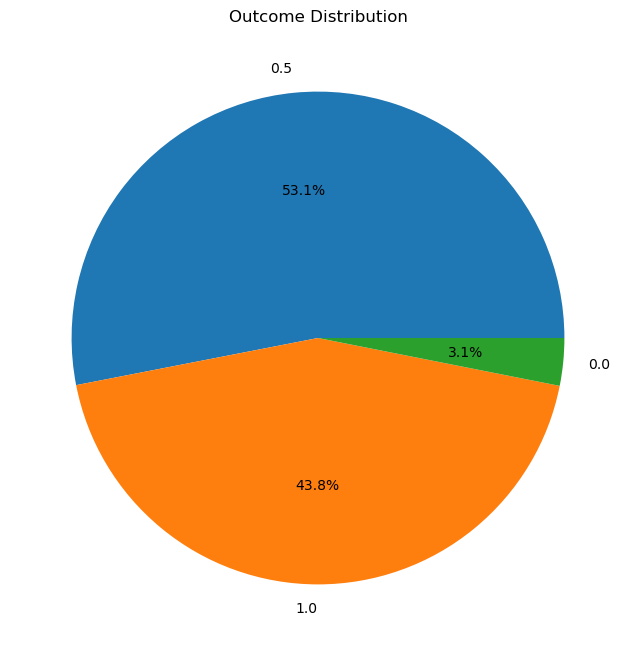

In [41]:
print("Shape: ", copy_df.shape)
print("\nCounts:\n", copy_df["Outcome"].value_counts())

print()

plt.figure(figsize=(8,8))
plt.pie(copy_df["Outcome"].value_counts(), labels = copy_df["Outcome"].value_counts().index, autopct="%1.1f%%")
plt.title("Outcome Distribution")
plt.show()

In [62]:
copy_df.describe()

Age       Gender  Nationality      Emirate  Diagnosis_Date  \
count  9251.000000  9251.000000  9251.000000  9251.000000     9251.000000   
mean      0.601661     0.259431     0.405578     0.493172        0.509920   
std       0.232831     0.268200     0.491030     0.334608        0.288592   
min       0.202247     0.000000     0.000000     0.000000        0.000000   
25%       0.404494     0.000000     0.000000     0.166667        0.258730   
50%       0.595506     0.000000     0.000000     0.500000        0.520317   
75%       0.808989     0.500000     1.000000     0.833333        0.758730   
max       1.000000     1.000000     1.000000     1.000000        1.000000   

       Cancer_Type  Cancer_Stage  Treatment_Type  Treatment_Start_Date  \
count  9251.000000   9251.000000     9251.000000           9251.000000   
mean      0.497027      0.453032        0.501027              0.508302   
std       0.325929      0.335257        0.372068              0.282307   
min       0.000000      0.000000        0.000000              0.000000   
25%       0.285714      0.333333        0.333333              0.260080   
50%       0.428571      0.333333        0.666667              0.515235   
75%       0.714286      0.666667        0.666667              0.752693   
max       1.000000      1.000000        1.000000              1.000000   

          Hospital  Primary_Physician   Death_Date  Cause_of_Death  \
count  9251.000000        9251.000000  9251.000000     9251.000000   
mean      0.497171           0.501772     0.991112        0.984434   
std       0.373026           0.289529     0.057519        0.086842   
min       0.000000           0.000000     0.424452        0.500000   
25%       0.000000           0.250842     1.000000        1.000000   
50%       0.666667           0.504006     1.000000        1.000000   
75%       0.666667           0.752119     1.000000        1.000000   
max       1.000000           1.000000     1.000000        1.000000   

       Smoking_Status  Comorbidities    Ethnicity       Weight       Height  \
count     9251.000000    9251.000000  9251.000000  9251.000000  9251.000000   
mean         0.555670       0.667964     0.502243     0.570427     0.814178   
std          0.346929       0.333871     0.356145     0.120949     0.047756   
min          0.000000       0.000000     0.000000     0.204918     0.673077   
25%          0.500000       0.333333     0.250000     0.491803     0.783654   
50%          0.500000       0.666667     0.500000     0.573770     0.812500   
75%          1.000000       1.000000     0.750000     0.655738     0.846154   
max          1.000000       1.000000     1.000000     0.934426     0.956731   

           Outcome  
count  9251.000000  
mean      0.703546  
std       0.275529  
min       0.000000  
25%       0.500000  
50%       0.500000  
75%       1.000000  
max       1.000000

In [64]:
copy_df.corr()

Age    Gender  Nationality   Emirate  \
Age                   1.000000 -0.016812     0.006933  0.008660   
Gender               -0.016812  1.000000    -0.007295  0.007393   
Nationality           0.006933 -0.007295     1.000000  0.002052   
Emirate               0.008660  0.007393     0.002052  1.000000   
Diagnosis_Date        0.010407 -0.027999     0.012153  0.009947   
Cancer_Type          -0.002866  0.006968     0.002709 -0.001402   
Cancer_Stage         -0.004160 -0.007146     0.006714  0.030201   
Treatment_Type       -0.007182  0.001122    -0.006422 -0.012511   
Treatment_Start_Date  0.009401 -0.027875     0.013740  0.010107   
Hospital             -0.000364 -0.012115     0.002722  0.007183   
Primary_Physician     0.013383 -0.008562    -0.010887  0.007121   
Death_Date           -0.015178  0.007560     0.002332  0.011685   
Cause_of_Death       -0.017068  0.012106    -0.002781  0.009053   
Smoking_Status        0.004968  0.003652    -0.006583  0.000559   
Comorbidities        -0.019682  0.011333     0.003825  0.007015   
Ethnicity            -0.012805  0.000132     0.006079 -0.001346   
Weight                0.006893  0.001553    -0.006800 -0.012786   
Height               -0.005805 -0.010194    -0.003316 -0.012987   
Outcome              -0.003381  0.003644    -0.016144 -0.006910   

                      Diagnosis_Date  Cancer_Type  Cancer_Stage  \
Age                         0.010407    -0.002866     -0.004160   
Gender                     -0.027999     0.006968     -0.007146   
Nationality                 0.012153     0.002709      0.006714   
Emirate                     0.009947    -0.001402      0.030201   
Diagnosis_Date              1.000000     0.018537      0.002459   
Cancer_Type                 0.018537     1.000000      0.012962   
Cancer_Stage                0.002459     0.012962      1.000000   
Treatment_Type             -0.014989     0.007677     -0.004934   
Treatment_Start_Date        0.998548     0.017843      0.002565   
Hospital                   -0.011923     0.016264      0.014234   
Primary_Physician          -0.005853     0.014956      0.000475   
Death_Date                 -0.057270    -0.004947      0.000243   
Cause_of_Death             -0.122146    -0.013912     -0.006548   
Smoking_Status             -0.019741     0.004673     -0.012373   
Comorbidities              -0.009927    -0.018462     -0.009651   
Ethnicity                  -0.018450     0.009654     -0.019603   
Weight                     -0.005663    -0.006374      0.006344   
Height                     -0.016673     0.022357     -0.012461   
Outcome                    -0.054982     0.002181     -0.002410   

                      Treatment_Type  Treatment_Start_Date  Hospital  \
Age                        -0.007182              0.009401 -0.000364   
Gender                      0.001122             -0.027875 -0.012115   
Nationality                -0.006422              0.013740  0.002722   
Emirate                    -0.012511              0.010107  0.007183   
Diagnosis_Date             -0.014989              0.998548 -0.011923   
Cancer_Type                 0.007677              0.017843  0.016264   
Cancer_Stage               -0.004934              0.002565  0.014234   
Treatment_Type              1.000000             -0.015499  0.011553   
Treatment_Start_Date       -0.015499              1.000000 -0.012061   
Hospital                    0.011553             -0.012061  1.000000   
Primary_Physician          -0.004403             -0.006121  0.010450   
Death_Date                  0.006880             -0.057463  0.004624   
Cause_of_Death              0.006629             -0.122745  0.012546   
Smoking_Status              0.002628             -0.019502  0.003862   
Comorbidities               0.004051             -0.010591  0.004080   
Ethnicity                   0.003144             -0.018260  0.007812   
Weight                     -0.009359             -0.005860  0.005359   
Height                      0.012778             

In [66]:
kstest(X, "norm").pvalue #p-value for each row

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

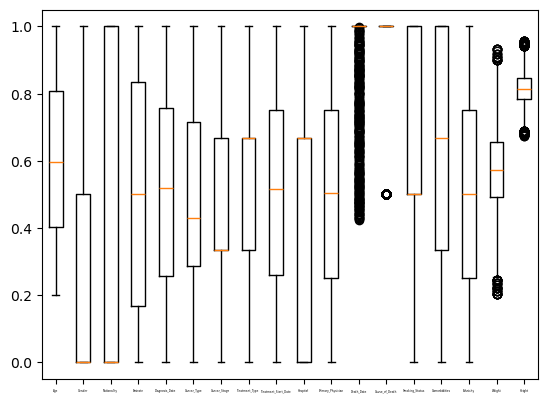

In [68]:
import seaborn as sn

#When dealing with very large data-sets/working with others using graphs to see things would be beneficial to everyone's sanity
fig, ax = plt.subplots()
ax.boxplot(X)
ax.set_xticklabels(X.columns, size=2)
plt.show()

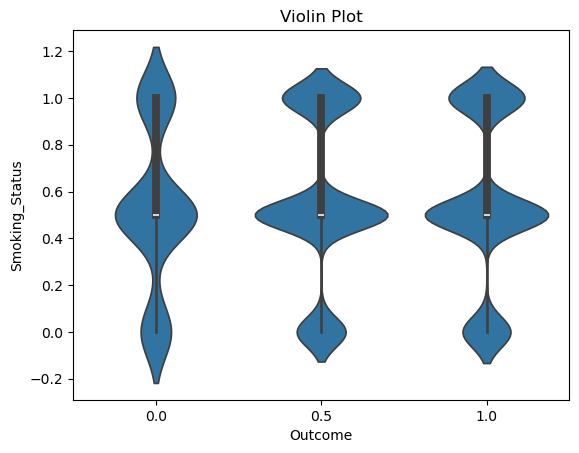

In [70]:
sn.violinplot(x="Outcome", y="Smoking_Status", data=copy_df)
plt.title("Violin Plot")
plt.show()

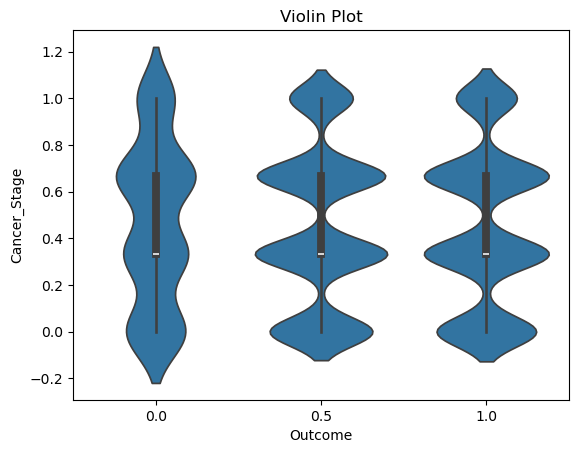

In [72]:
sn.violinplot(x="Outcome", y="Cancer_Stage", data=copy_df)
plt.title("Violin Plot")
plt.show()

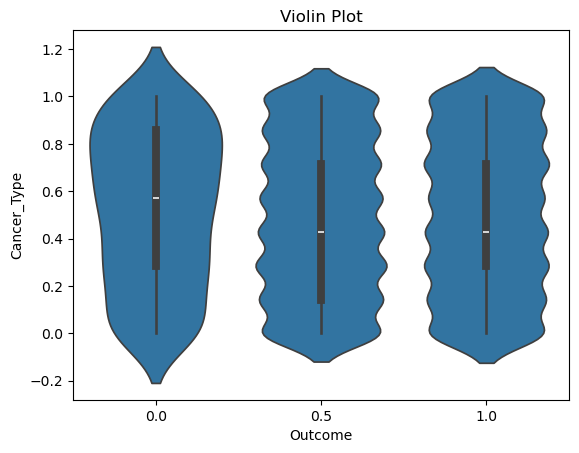

In [74]:
sn.violinplot(x="Outcome", y="Cancer_Type", data=copy_df)
plt.title("Violin Plot")
plt.show()

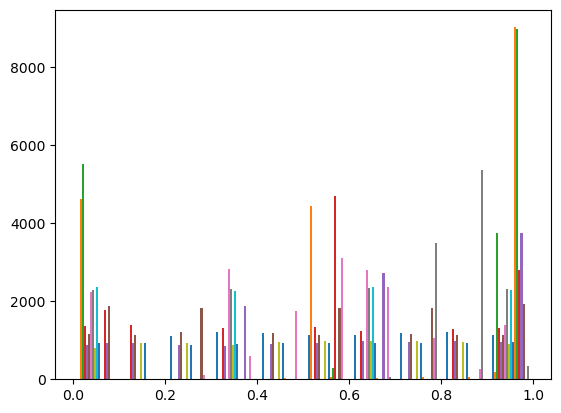

In [76]:
plt.hist(X)
plt.show()

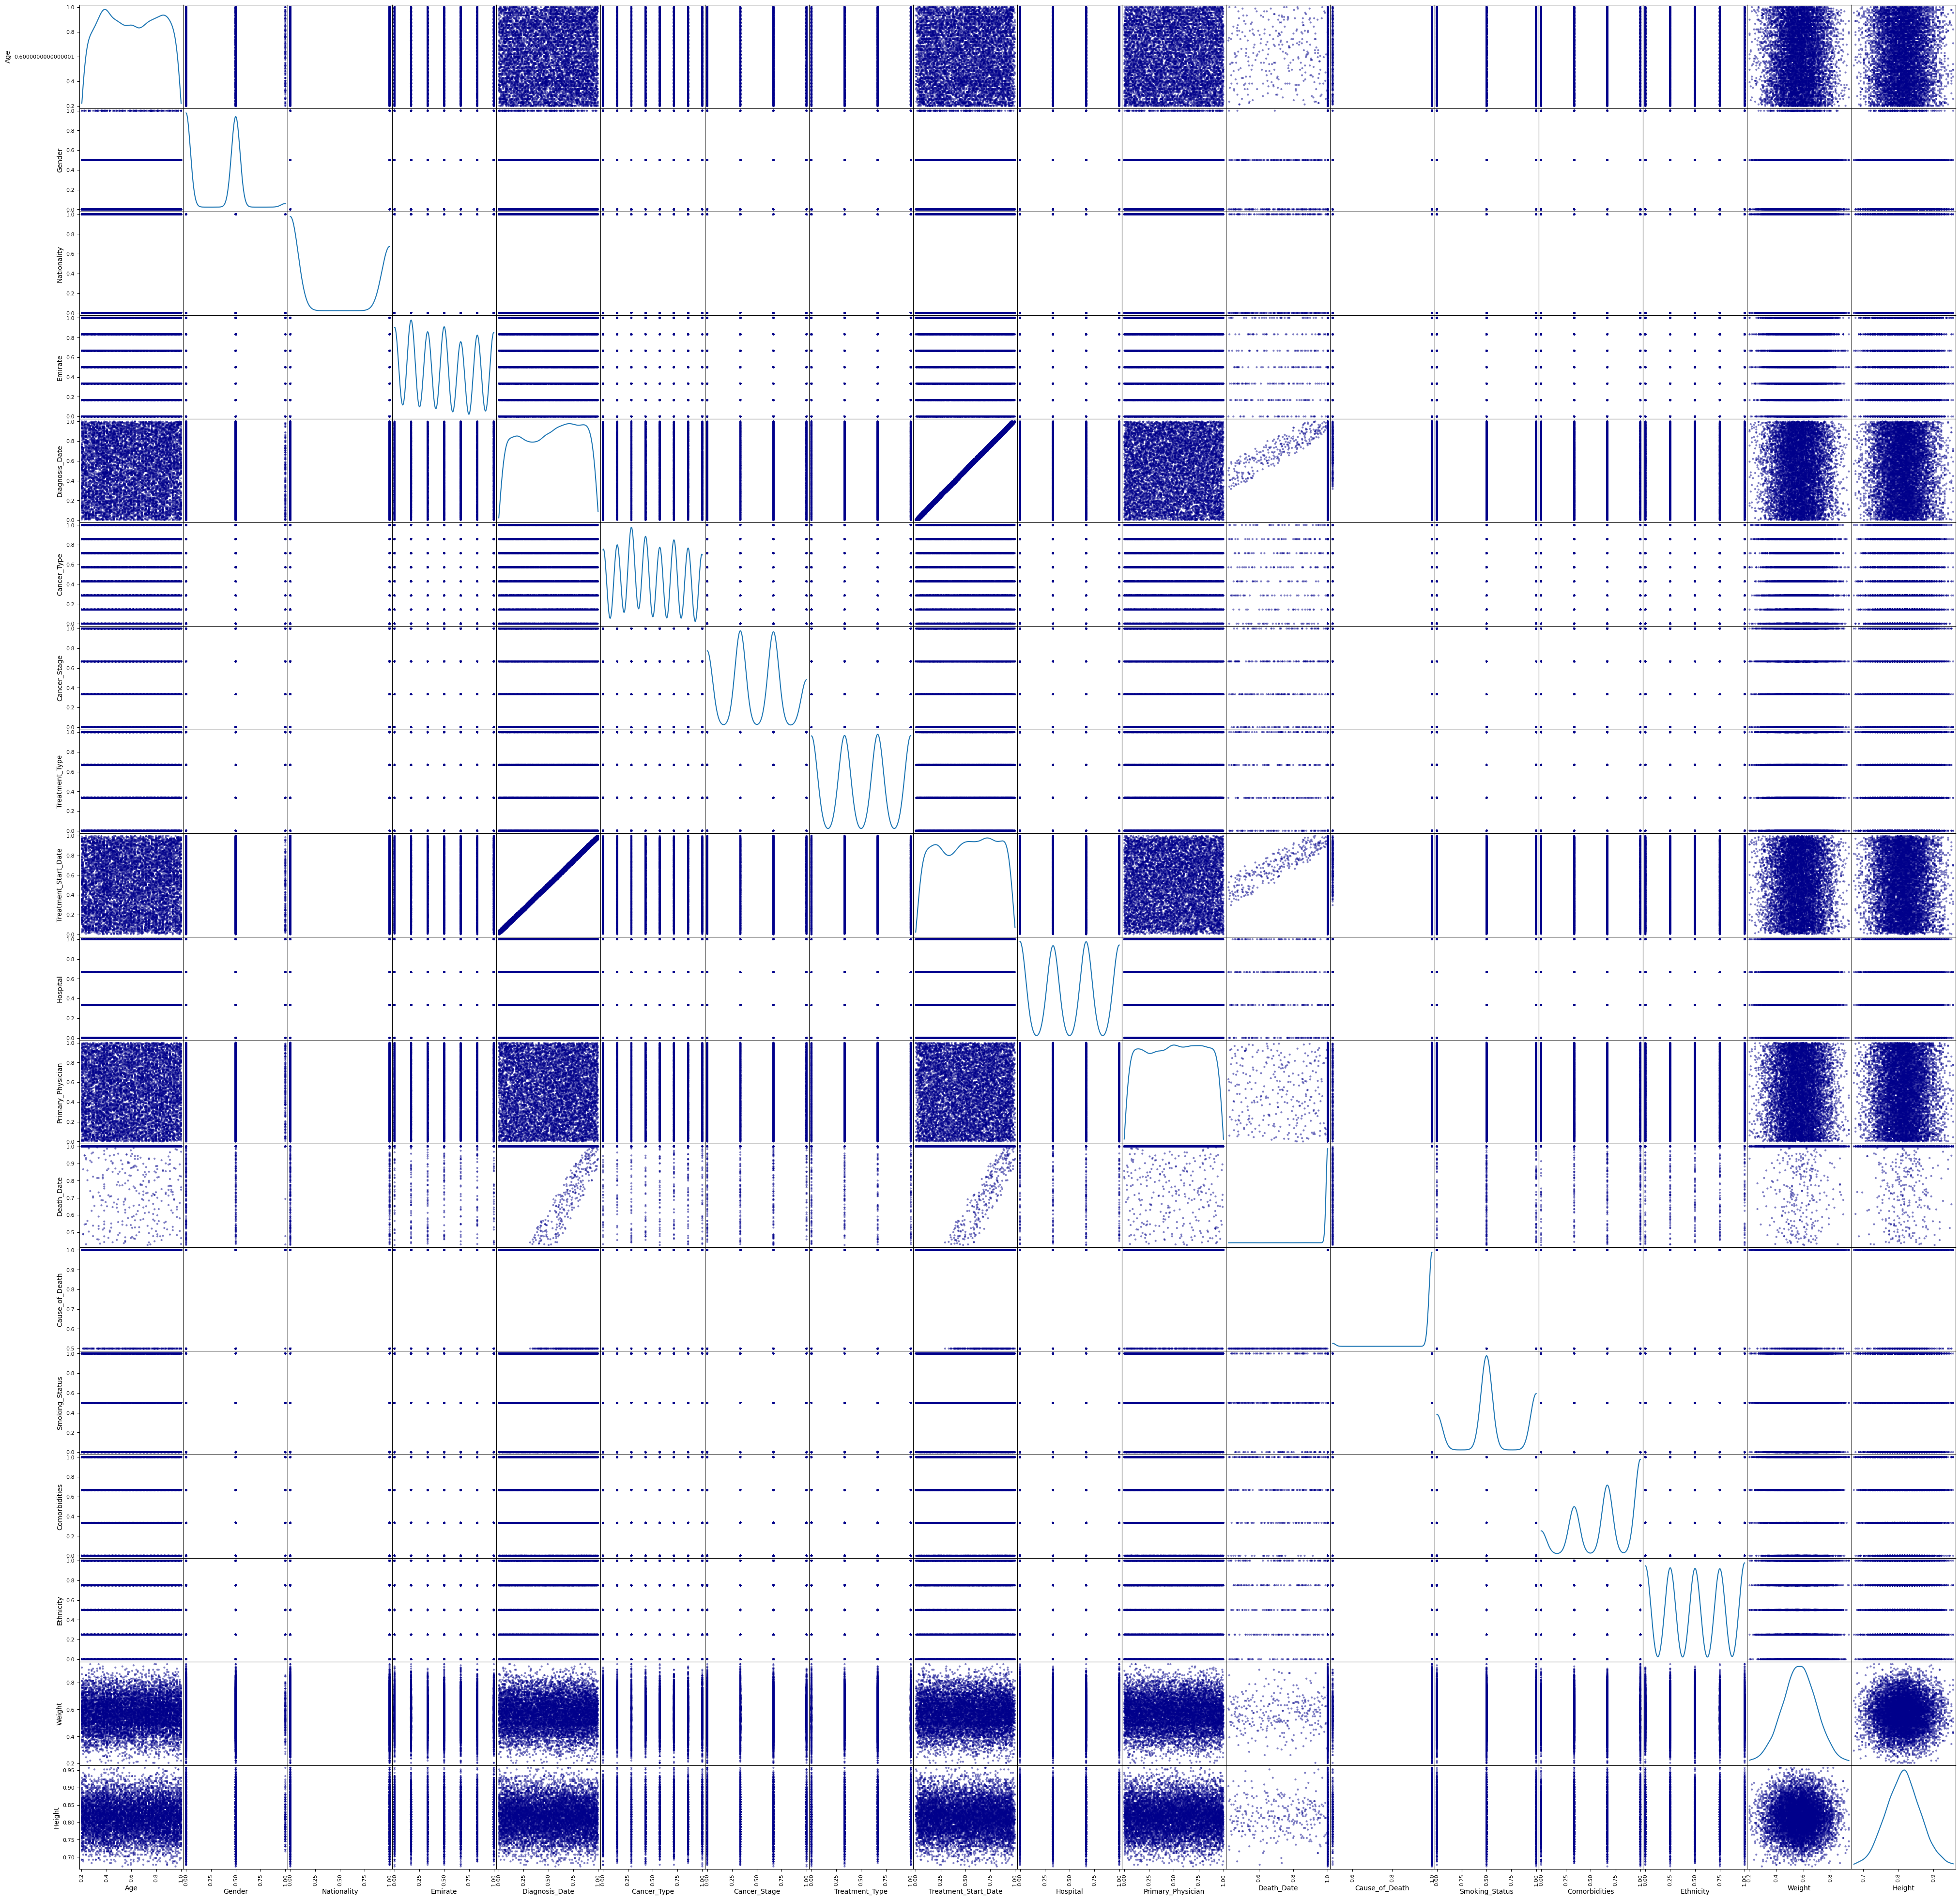

In [78]:
from pandas.plotting import scatter_matrix

scatter_matrix(X, alpha = 0.5, figsize = (50, 50), diagonal = "kde", c="#00008B");

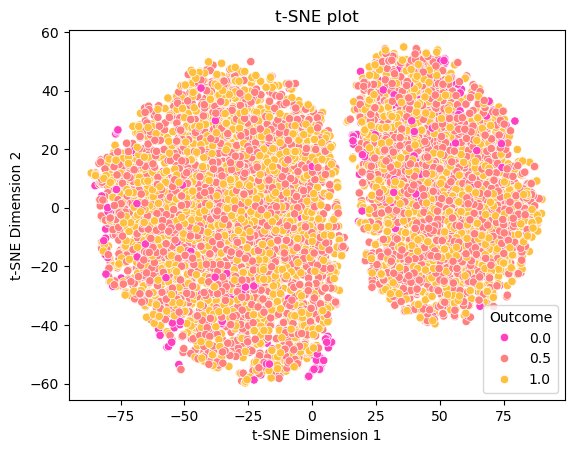

In [84]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, random_state = 42)
X_embedded = tsne.fit_transform(X)

n_classes = len(np.unique(y))
palette = sn.color_palette("spring", n_classes)

sn.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y, palette=palette)
plt.title("t-SNE plot")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

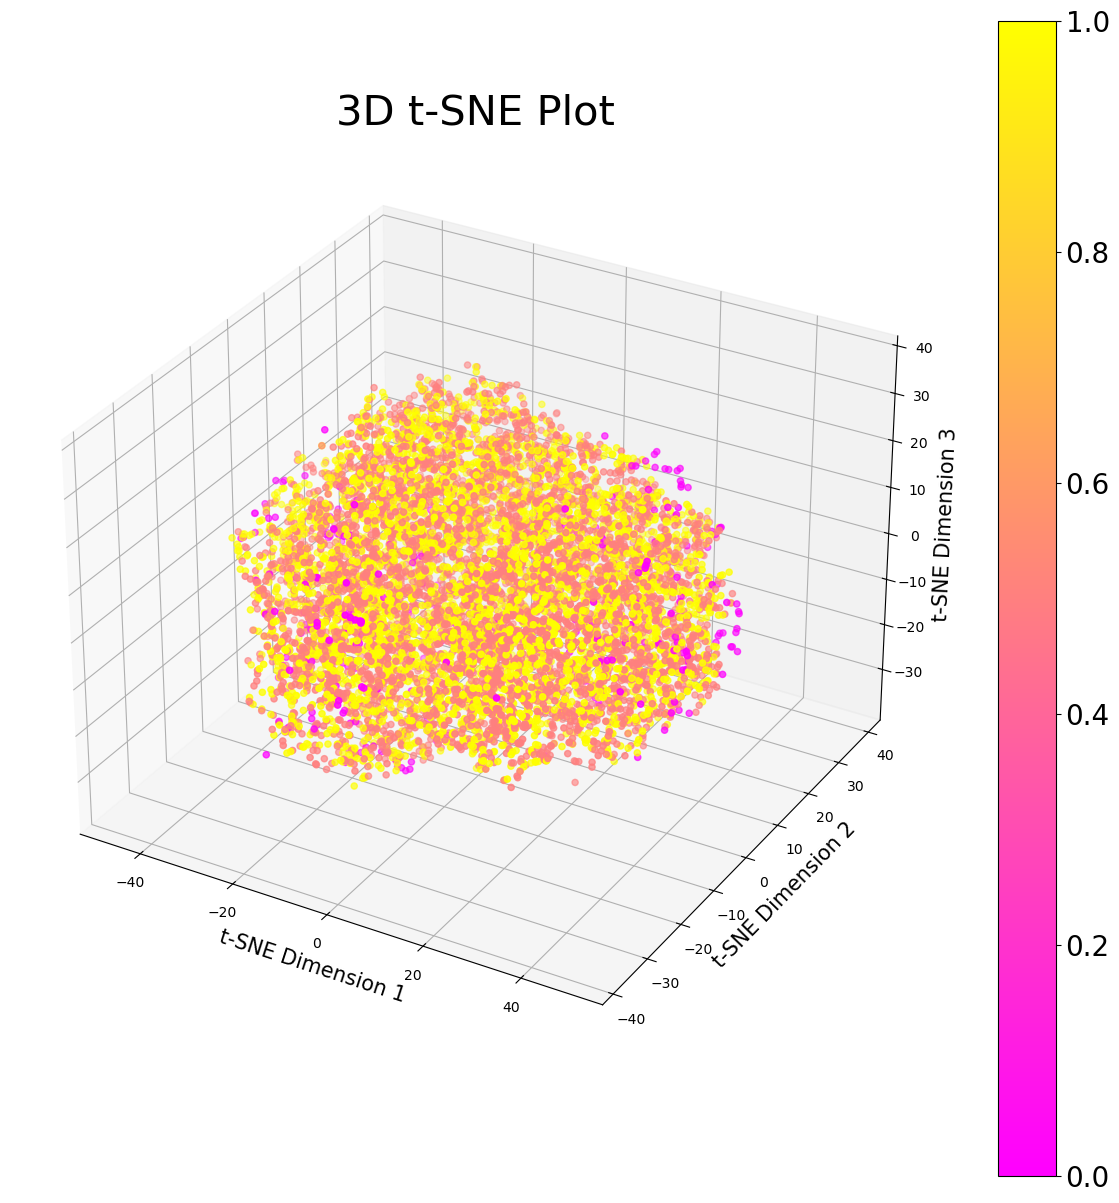

In [101]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(X)

fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=y, cmap="spring")

ax.set_title("3D t-SNE Plot", fontsize=30)
ax.set_xlabel("t-SNE Dimension 1", fontsize=15)
ax.set_ylabel("t-SNE Dimension 2", fontsize=15)
ax.set_zlabel("t-SNE Dimension 3", fontsize=15)

cbar = plt.colorbar(sc)
cbar.ax.tick_params(labelsize=20)

plt.show()

## Data Optimization ##

In [600]:
#Linear Algebra Operations
d = copy_df[~copy_df["Outcome"].map(lambda x: isinstance(x, list)) & (copy_df["Outcome"] == 0)]
copy_df = copy_df[~((copy_df["Outcome"] == 0) & copy_df["Outcome"].map(lambda x: not isinstance(x, list)))]
vec_df = np.dot(d, 1.54) #Operations to weight data

#re-inserting weighted data back into the dataset
v = pd.DataFrame(vec_df, columns = copy_df.columns[0:20])
copy_df = pd.concat([copy_df, v])

In [596]:
#Linear Algebra Operations
d = copy_df[~copy_df["Outcome"].map(lambda x: isinstance(x, list)) & (copy_df["Outcome"] == 0)]
copy_df = copy_df[~((copy_df["Outcome"] == 0) & copy_df["Outcome"].map(lambda x: not isinstance(x, list)))]
vec_df = np.dot(d, 1/1.54) #Operations to weight data

#re-inserting weighted data back into the dataset
v = pd.DataFrame(vec_df, columns = copy_df.columns[0:20])
copy_df = pd.concat([copy_df, v])

In [602]:
drop()
copy_df.reset_index(drop=True)

Age  Gender  Nationality   Emirate  Diagnosis_Date  Cancer_Type  \
0     0.775281    0.00         0.00  1.000000        0.646984     0.428571   
1     0.359551    0.50         0.00  1.000000        0.085714     0.285714   
2     1.000000    0.50         0.00  0.000000        0.340635     0.428571   
3     0.876404    0.00         0.00  0.000000        0.775238     0.571429   
4     0.426966    0.00         0.00  0.500000        0.537143     0.857143   
...        ...     ...          ...       ...             ...          ...   
9246  0.657528    0.77         0.00  1.283333        1.440756     0.660000   
9247  0.657528    0.77         1.54  1.540000        0.962133     1.100000   
9248  0.397978    0.00         1.54  0.000000        1.519956     1.320000   
9249  0.951685    0.77         1.54  0.000000        1.098044     0.440000   
9250  0.934382    0.00         0.00  1.026667        0.752400     0.000000   

      Cancer_Stage  Treatment_Type  Treatment_Start_Date  Hospital  \
0         0.333333        0.666667              0.614651  0.666667   
1         0.666667        1.000000              0.076639  0.333333   
2         0.666667        0.666667              0.366882  1.000000   
3         0.666667        0.666667              0.751924  0.000000   
4         0.333333        0.000000              0.533395  0.666667   
...            ...             ...                   ...       ...   
9246      1.540000        1.540000              1.437144  0.000000   
9247      0.513333        0.000000              0.983059  1.026667   
9248      1.540000        1.540000              1.517722  0.000000   
9249      1.026667        0.000000              1.097291  1.026667   
9250      1.026667        1.540000              0.762653  1.026667   

      Primary_Physician  Death_Date  Cause_of_Death  Smoking_Status  \
0              0.828863    1.000000            1.00            0.50   
1              0.708116    1.000000            1.00            1.00   
2              0.042842    1.000000            1.00            0.50   
3              0.729130    1.000000            1.00            0.00   
4              0.948914    1.000000            1.00            0.00   
...                 ...         ...             ...             ...   
9246           1.178825    1.456517            0.77            0.77   
9247           0.948531    1.088835            0.77            0.77   
9248           0.191137    1.522238            0.77            1.54   
9249           0.684087    1.007128            0.77            1.54   
9250           1.223704    0.726482            0.77            1.54   

      Comorbidities  Ethnicity    Weight    Height  Outcome  
0          1.000000       0.75  0.500000  0.754808      0.5  
1          1.000000       1.00  0.655738  0.841346      0.5  
2          1.000000       1.00  0.409836  0.841346      1.0  
3          1.000000       0.00  0.360656  0.745192      0.5  
4          1.000000       0.50  0.827869  0.769231      0.5  
...             ...        ...       ...       ...      ...  
9246       1.540000       0.00  0.795246  1.465962      0.0  
9247       0.000000       1.54  1.035082  1.229038      0.0  
9248       1.540000       0.77  0.770000  1.251250      0.0  
9249       1.540000       1.54  0.959344  1.347500      0.0  
9250       0.513333       0.00  0.618525  1.236442      0.0  

[9251 rows x 19 columns]

## Training Model ##

In [604]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [606]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

In [608]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(6475, 18)
(1388, 18)
(1388, 18)


In [610]:
class dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(np.array(X), dtype = torch.float32).to(device)
        self.y = torch.tensor(np.array(y), dtype = torch.float32).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [612]:
training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

In [614]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [616]:
train_dataloader = DataLoader(training_data, batch_size = BATCH_SIZE, shuffle = True)
validation_dataloader = DataLoader(validation_data, batch_size = BATCH_SIZE, shuffle = True)
testing_dataloader = DataLoader(testing_data, batch_size = BATCH_SIZE, shuffle = True)

In [618]:
Hidden_Neurons = 25

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.input_layer = nn.Linear(X.shape[1], Hidden_Neurons)
        self.dropout = nn.Dropout(0.25)

        
        self.hidden_layer1 = nn.Linear(X.shape[1], Hidden_Neurons)
        self.hidden_layer2 = nn.Linear(Hidden_Neurons, Hidden_Neurons)
        self.hidden_layer3 = nn.Linear(Hidden_Neurons, Hidden_Neurons)
        
        self.linear = nn.Linear(Hidden_Neurons, 1) #output layer
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        #Forward Propagation
        x = x.to(device)
        x = self.input_layer(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

model = MyModel().to(device)

In [620]:
summary(model)

Layer (type:depth-idx)                   Param #
MyModel                                  --
├─Linear: 1-1                            475
├─Dropout: 1-2                           --
├─Linear: 1-3                            475
├─Linear: 1-4                            650
├─Linear: 1-5                            650
├─Linear: 1-6                            26
├─Sigmoid: 1-7                           --
Total params: 2,276
Trainable params: 2,276
Non-trainable params: 0

In [622]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = LR)

In [624]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

start_time = time.time()

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0

    for data in train_dataloader:
        inputs, labels = data

        prediction = model(inputs).squeeze(1)

        batch_loss = criterion(prediction, labels)
        
        total_loss_train += batch_loss.item()

        acc = ((prediction).round() == labels).sum().item()

        total_acc_train += acc

        #Back Propagation
        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    with torch.no_grad():
        for data in validation_dataloader:
            inputs, labels = data

            prediction = model(inputs).squeeze(1)

            batch_loss = criterion(prediction, labels)
        
            total_loss_val += batch_loss.item()

            acc = ((prediction).round() == labels).sum().item()

            total_acc_val += acc
        
    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    
    total_acc_train_plot.append(round(total_acc_train/training_data.__len__()*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/validation_data.__len__()*100, 4))

    print(f'''Epoch no. {epoch+1} 
    Training Loss: {round(total_loss_train/1000, 4)} 
    Training Accuracy: {round(total_acc_train/training_data.__len__()*100, 4)} 
    Validation Loss: {round(total_loss_val/1000, 4)} 
    Validation Accuracy: {round(total_acc_val/validation_data.__len__()*100, 4)}''')

    print("="*50)

print("Training Time is: ", round((time.time() - start_time), 4), " Seconds")

Epoch no. 1 
    Training Loss: 12.6461 
    Training Accuracy: 17.3745 
    Validation Loss: 2.7092 
    Validation Accuracy: 6.8444
Epoch no. 2 
    Training Loss: 12.6386 
    Training Accuracy: 3.6911 
    Validation Loss: 2.7083 
    Validation Accuracy: 3.8184
Epoch no. 3 
    Training Loss: 12.6345 
    Training Accuracy: 3.0734 
    Validation Loss: 2.7069 
    Validation Accuracy: 3.8184
Epoch no. 4 
    Training Loss: 12.6306 
    Training Accuracy: 3.0888 
    Validation Loss: 2.7059 
    Validation Accuracy: 3.9625
Epoch no. 5 
    Training Loss: 12.6279 
    Training Accuracy: 3.4749 
    Validation Loss: 2.7058 
    Validation Accuracy: 5.4035
Epoch no. 6 
    Training Loss: 12.6257 
    Training Accuracy: 6.7181 
    Validation Loss: 2.7053 
    Validation Accuracy: 9.5821
Epoch no. 7 
    Training Loss: 12.6226 
    Training Accuracy: 17.2664 
    Validation Loss: 2.704 
    Validation Accuracy: 23.487
Epoch no. 8 
    Training Loss: 12.6201 
    Training Accuracy: 31.8

In [638]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for inputs, labels in testing_dataloader:
        inputs, labels = data
        prediction = model(inputs).squeeze(1)

        batch_loss_test = criterion(prediction, labels).item()
        total_loss_test += batch_loss_test
        
        acc = (prediction.round() == labels).sum().item()
        
        total_acc_test += acc
        total_loss_test += batch_loss_test

print(f'''Accuracy Score: {round(total_acc_test/testing_data.__len__()*100, 4)} 
Loss: {round(total_loss_test/1000, 4)}''')

Accuracy Score: 50.1441 
Loss: 4.3291


## Post-Training Analysis ##

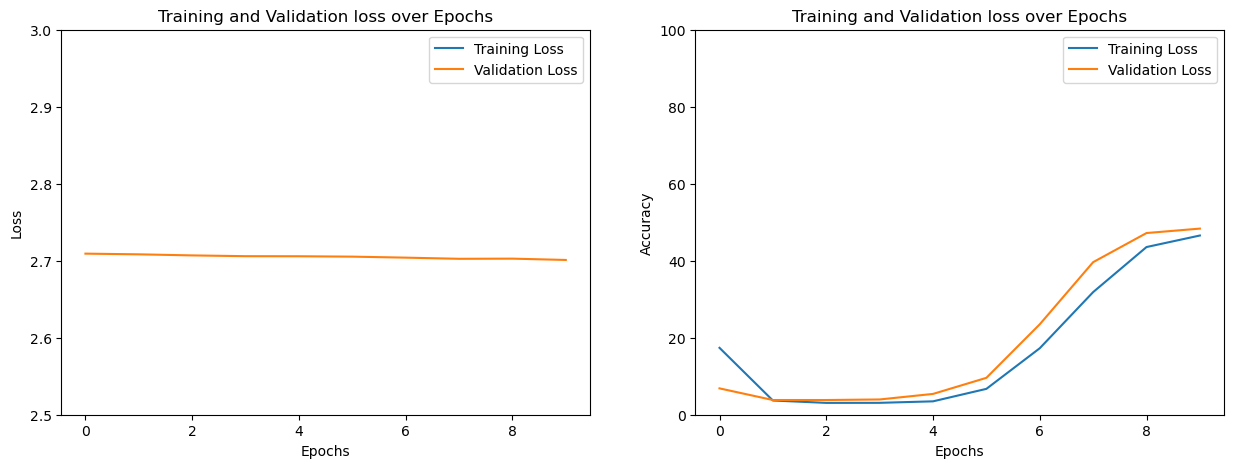

In [632]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

axs[0].plot(total_loss_train_plot, label = "Training Loss")
axs[0].plot(total_loss_validation_plot, label = "Validation Loss")
axs[0].set_title("Training and Validation loss over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([2.5,3])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = "Training Loss")
axs[1].plot(total_acc_validation_plot, label = "Validation Loss")
axs[1].set_title("Training and Validation loss over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_ylim([0,100])
axs[1].legend()

plt.show()

In [634]:
torch.save(model.state_dict(), "model.pth")

In [636]:
loaded_model = MyModel().to(device)
loaded_model.load_state_dict(torch.load("model.pth"))
loaded_model.eval()

MyModel(
  (input_layer): Linear(in_features=18, out_features=25, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (hidden_layer1): Linear(in_features=18, out_features=25, bias=True)
  (hidden_layer2): Linear(in_features=25, out_features=25, bias=True)
  (hidden_layer3): Linear(in_features=25, out_features=25, bias=True)
  (linear): Linear(in_features=25, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

## Report ##

1. Obvious overfitting, however the main goal of engineering a better training accuracy was successful (you'd think I'd do this more considering that's the field I'm interested in 🤦‍♂️)
2. Testing accuracy went from ~30% to 50.1441%